In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [84]:
data = pd.read_excel('../dataset/clean_dataset.xlsx')
data = data.sample(frac = 1, random_state=7).reset_index(drop=True)

In [85]:
aux_df = data.copy()
aux_df

,id,Label_1,Label_2,Original,Quantity,Price,Text
0,5398,742,414,COMBODART 0 5MG+0 4MG 30CAP GEL DURA,2,118.66,COMBODART 5MG 4MG 30CAP GEL DURA
1,318,37,11,ACETILCISTEINA AD XPE 120ML,1,23.33,ACETILCISTEINA AD XPE 120ML
2,5069,686,378,CLORIDRATO DE HIDROXIZINA 25 MG C/ 30 CPR,2,14.99,CLORIDRATO DE HIDROXIZINA 25 MG 30 CPR
3,14796,2274,1136,OPTIVE COL 10 ML*,1,51.74,OPTIVE COL 10 ML
4,16049,2470,1222,PRESSALIV 5ML,1,74.15,PRESSALIV 5ML
...,...,...,...,...,...,...,...
21111,919,129,64,ALENIA 12/400MCG C/60CAPS+INALADOR,1,145.82,ALENIA 12 400MCG 60CAPS INALADOR
21112,20691,3172,1522,VICOG 5MG C/30 COMP,1,25.11,VICOG 5MG 30 COMP
21113,5699,788,442,CYSTEX FR 24 DRG,1,20.22,CYSTEX FR 24 DRG
21114,10742,1528,753,GEN-NIMESULIDA 100MG C/12 LEGR,1,7.00,GEN NIMESULIDA 100MG 12 LEGR


In [86]:
# data.drop('Text', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)
data.drop('Original', axis=1, inplace=True)
data.drop('Label_1', axis=1, inplace=True)
data.drop('Label_2', axis=1, inplace=True)
SEQLEN = 10
EMBEDDING_SIZE = 10

In [87]:
text_input = data.pop('Text')

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='',
    lower=True, split=' ')
tokenizer.fit_on_texts(text_input)
vocab_size = len(tokenizer.word_index)

x = tokenizer.texts_to_sequences(text_input)   
res = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=SEQLEN,
                                                    padding='post')
data

,Quantity,Price
0,2,118.66
1,1,23.33
2,2,14.99
3,1,51.74
4,1,74.15
...,...,...
21111,1,145.82
21112,1,25.11
21113,1,20.22
21114,1,7.00


In [88]:
standard_scaler = StandardScaler()
data_standard = standard_scaler.fit_transform(data)

data_in = {'data_input': data_standard, 'text_input': res}
data_out = {'decoded_data': data_standard, 'decoded_txt': res}

print(data_in['data_input'].shape)
print(data_in['text_input'].shape)

(21116, 2)
(21116, 10)


In [89]:
len_data = data_in["data_input"].shape[1]

# Data Input
data_input = tf.keras.layers.Input(shape=(len_data, ), name='data_input')

# Text Input
text_input = tf.keras.layers.Input(shape=(SEQLEN,), name='text_input')
x = tf.keras.layers.Embedding(vocab_size + 1, EMBEDDING_SIZE,
                              input_length=SEQLEN)(text_input)
text_output = tf.keras.layers.LSTM(SEQLEN, activation='relu')(x)

# Concatenate Inputs
concat_inputs = tf.keras.layers.concatenate([data_input, text_output])

# Encoder
encoded = tf.keras.layers.Dense(16, activation='relu')(concat_inputs)
# encoded = tf.keras.layers.Dropout(0.2)(encoded)
encoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
# encoded = tf.keras.layers.Dropout(0.2)(encoded)
encoded = tf.keras.layers.Dense(4, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(4, activation='relu')(encoded)
# decoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = tf.keras.layers.Dense(8, activation='relu')(decoded)
# decoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = tf.keras.layers.Dense(16, activation='relu')(decoded)

decoded_data = tf.keras.layers.Dense(len_data, name='decoded_data')(decoded)
decoded_text = tf.keras.layers.Dense(SEQLEN, name='decoded_txt')(decoded)

decoded = [decoded_data, decoded_text]

# Autoencoder model
ae_input_layers = {'data_input': data_input,
                   'text_input': text_input}

ae_output_layers = {'decoded_data': decoded[0],
                    'decoded_txt': decoded[1]}

autoencoder = tf.keras.Model(ae_input_layers, ae_output_layers)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss='mse',
                    metrics=['mse', 'mae'])
print(autoencoder.summary())

# early_stopping = utils.early_stopping_cb('val_mse', 5, 'min')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 10, 10)       39450       text_input[0][0]                 
__________________________________________________________________________________________________
data_input (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 10)           840         embedding_3[0][0]                
____________________________________________________________________________________________

In [157]:
history = autoencoder.fit(data_in, data_out,
                          epochs=50,
                          validation_split=0.2
                            )

predicted = autoencoder.predict(final_data)

==================] - 3s 5ms/step - loss: 102482.0078 - decoded_data_loss: 1.8123 - decoded_txt_loss: 102480.1641 - decoded_data_mse: 1.8123 - decoded_data_mae: 0.5324 - decoded_txt_mse: 102480.1641 - decoded_txt_mae: 135.1917 - val_loss: 128163.0938 - val_decoded_data_loss: 0.3974 - val_decoded_txt_loss: 128162.6641 - val_decoded_data_mse: 0.3974 - val_decoded_data_mae: 0.4614 - val_decoded_txt_mse: 128162.6641 - val_decoded_txt_mae: 137.2413
Epoch 10/50
528/528 [==============================] - 3s 5ms/step - loss: 102409.4531 - decoded_data_loss: 1.8458 - decoded_txt_loss: 102407.5703 - decoded_data_mse: 1.8458 - decoded_data_mae: 0.5214 - decoded_txt_mse: 102407.5703 - decoded_txt_mae: 134.4319 - val_loss: 128235.0156 - val_decoded_data_loss: 0.3583 - val_decoded_txt_loss: 128234.6328 - val_decoded_data_mse: 0.3583 - val_decoded_data_mae: 0.4017 - val_decoded_txt_mse: 128234.6328 - val_decoded_txt_mae: 139.2135
Epoch 11/50
528/528 [==============================] - 3s 5ms/step - lo

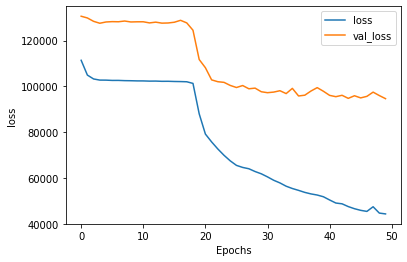

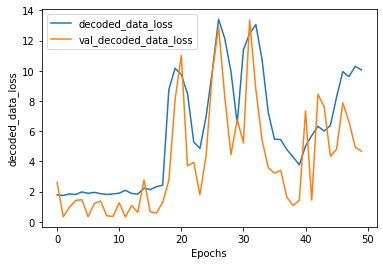

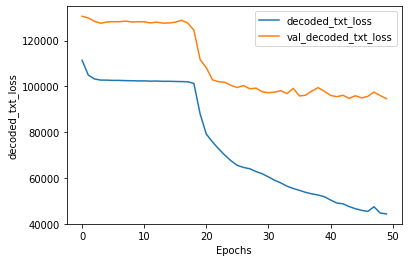

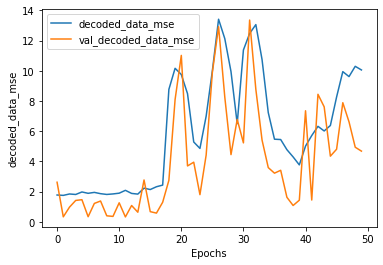

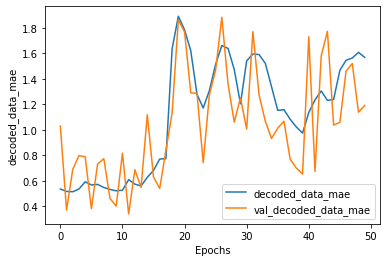

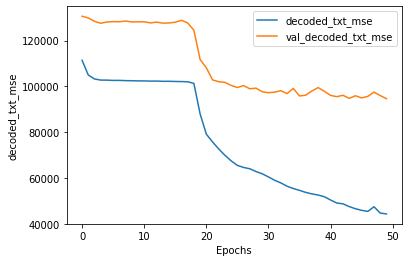

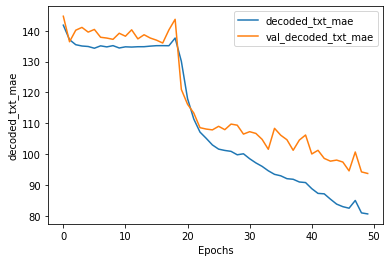

In [159]:
metrics = ['loss', 'decoded_data_loss', 'decoded_txt_loss', 'decoded_data_mse', 'decoded_data_mae', 'decoded_txt_mse', 'decoded_txt_mae']
for metric in metrics:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plot_name = '../results/' + metric + '.svg'
    plt.savefig(plot_name)
    plt.show()

In [192]:
df = aux_df.copy()

In [193]:
df['Cluster'] = 0
df['decoded_txt'] = predicted['decoded_txt'].std(axis=1).tolist()
df['raw'] = predicted['decoded_txt'].tolist()

df = df.sort_values(by=['decoded_txt']).reset_index(drop=True)

df.loc[df['decoded_txt'] > df['decoded_txt'].shift(1)*1.000411, 'Cluster'] = 1
# df.loc[df['decoded_txt'] > df['decoded_txt'].shift(1)*1.0005, 'Cluster'] = 1

In [122]:
df.head()

,id,Label_1,Label_2,Original,Quantity,Price,Text,Cluster,decoded_txt,raw
0,9792,1360,670,FLORAX SM INFANTIL CX 5 FLAC.,4,30.41,FLORAX SM INFANTIL CX FLAC,0,18.783361,"[63.6889762878418, 30.586105346679688, 25.2289..."
1,9794,1360,670,FLORAX SM INFANTIL CX 5 FLAC.,4,30.41,FLORAX SM INFANTIL CX FLAC,0,18.783361,"[63.6889762878418, 30.586105346679688, 25.2289..."
2,9793,1360,670,FLORAX SM INFANTIL CX 5 FLAC.,3,30.41,FLORAX SM INFANTIL CX FLAC,0,18.783367,"[63.68899917602539, 30.58611488342285, 25.2289..."
3,9790,1360,670,FLORAX SM INFANTIL CX 5 FLAC.,3,30.41,FLORAX SM INFANTIL CX FLAC,0,18.783367,"[63.68899917602539, 30.58611488342285, 25.2289..."
4,9791,1360,670,FLORAX SM INFANTIL CX 5 FLAC.,1,30.41,FLORAX SM INFANTIL CX FLAC,1,18.783388,"[63.6890754699707, 30.586143493652344, 25.2289..."


In [194]:
df.groupby('Cluster')['id'].nunique()

Cluster
0    17842
1     3274
Name: id, dtype: int64

In [195]:
indicators = df['Cluster']
indicators

0        0
1        1
2        1
3        1
4        1
        ..
21111    1
21112    1
21113    1
21114    1
21115    1
Name: Cluster, Length: 21116, dtype: int64

In [196]:
x = 0
clusters = []
for ind in indicators:
    if(ind == 1):
        x += 1
    clusters.append(x)

In [197]:
df['Cluster'] = clusters
df

,id,Label_1,Label_2,Original,Quantity,Price,Text,Cluster,decoded_txt,raw
0,5055,681,376,CLORIDRATO DE DULOXETINA C1,1,288.93,CLORIDRATO DE DULOXETINA C1,0,4.611363,"[3.539562463760376, 3.383704900741577, 18.1794..."
1,5054,681,376,CLORIDRATO DE DULOXETINA C1,2,100.95,CLORIDRATO DE DULOXETINA C1,1,4.889643,"[1.6424269676208496, 3.4287850856781006, 19.20..."
2,15445,2358,1166,PATZ SL C1,1,98.93,PATZ SL C1,2,6.621637,"[7.880702972412109, 27.95120620727539, 14.9109..."
3,4984,669,366,CLORIDRATO DE AMITRIPTILINA C1,1,15.00,CLORIDRATO DE AMITRIPTILINA C1,3,7.432529,"[20.562149047851562, 28.57391929626465, 16.395..."
4,11463,1585,832,HISTAMIN 2MG 20CP,1,12.79,HISTAMIN 2MG 20CP,4,7.756515,"[30.577186584472656, 19.10039710998535, 16.340..."
...,...,...,...,...,...,...,...,...,...,...
21111,16543,2533,1257,PYR-PAM C/6 COMP. UCI-FARMA,1,25.73,PYR PAM 6 COMP UCI FARMA,3270,6919.695312,"[9136.6005859375, 23222.818359375, 3883.539794..."
21112,7044,894,479,DEXCLO BETA XPE 120MLKOIDE DL 207003/20 V,12,37.00,DEXCLO BETA XPE 120MLKOIDE DL 207003 20 V,3271,7016.786133,"[5969.52978515625, 24116.0546875, 3716.0649414..."
21113,13072,1926,974,MARACUJA CONCENTRIX 100 ML,1,22.86,MARACUJA CONCENTRIX 100 ML,3272,8939.669922,"[10014.4599609375, 30378.57421875, 4861.880859..."
21114,18994,2921,1409,TAXA DE ENTREGA GRATIS,1,0.01,TAXA DE ENTREGA GRATIS,3273,9007.833008,"[20225.298828125, 26525.869140625, 5520.945800..."


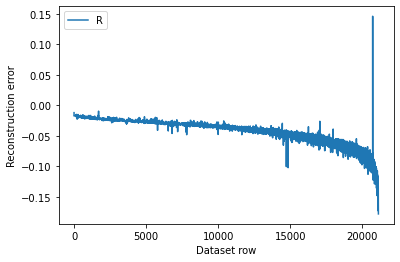

In [22]:
plt.plot(lol['decoded_pri'])
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()

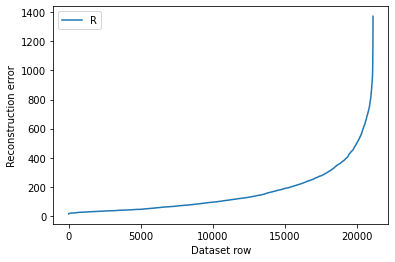

In [364]:
plt.plot(lol['decoded_txt'])
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()

In [198]:
df.to_excel("../dataset/autoencoder_1_50.xlsx", index=False)